# Estudo sobre features textuais de projetos culturais

Issue: [#243](https://github.com/lappis-unb/salic-ml/issues/243) Extração e análise de features textuais dos projetos culturais

## Objetivos

Extrair features textuais de projetos culturais do banco de dados do Salic a partir de todos os dados textuais (curtos e longos), como descrição, título, itens, objeto e etc. As features extraídas serão utilizadas para identificação de projetos culturais semelhantes.

---
## Preparação

Nesta etapa serão carregados e explorados os datasets a serem utilizados ao longo de todo o notebook. Serão analisados os datasets de itens orçamentários e o dataset de projetos culturais, ambos serão explorados em busca de features textuais. 

#### Importando módulos e definindo constantes

In [41]:
%pylab inline
import scipy
import pandas as pd
import seaborn as sns

from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /usr/share/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


### Explorando o dataset de itens orçamentários

In [2]:
df = pd.read_csv('../../data/raw/planilha_orcamentaria.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026756 entries, 0 to 2026755
Data columns (total 25 columns):
idPronac                int64
PRONAC                  int64
idPlanilhaAprovacao     int64
Item                    object
idPlanilhaItens         int64
Unidade                 object
QtDias                  int64
QtItem                  float64
nrOcorrencia            float64
VlUnitarioSolicitado    float64
VlTotalSolicitado       float64
VlUnitarioAprovado      float64
VlTotalAprovado         float64
UfItem                  object
MunicipioItem           object
Etapa                   object
idArea                  int64
Area                    object
idSegmento              object
Segmento                object
idProduto               int64
Produto                 object
DataProjeto             object
cdCidade                int64
cdEtapa                 int64
dtypes: float64(6), int64(9), object(10)
memory usage: 386.6+ MB


In [3]:
df.head(5).transpose()

,0,1,2,3,4
idPronac,121051,121051,121051,119968,112836
PRONAC,100855,100855,100855,98671,91695
idPlanilhaAprovacao,792860,792883,792903,109095,116511
Item,Passagens Aéreas (Descrever os trechos na tela...,Bonecos – Criação,Produtor executivo,Assistente de produção,Designer
idPlanilhaItens,131,3599,53,1037,103
Unidade,Unidade,Verba,Verba,Verba,Mês
QtDias,150,90,90,30,378
QtItem,40,1,3,1,1
nrOcorrencia,1,1,1,1,18
VlUnitarioSolicitado,150,4000,3000,1000,2000


O primeiro dataset explorado será o de itens orçamentários. Como mostrado acima, tal dataset conta com uma relação de mais de 2 milhões de itens de projetos culturais, desde projetos em fase inicial até projetos já finalizados. Cada item conta com 25 informações, como o identificador do projeto ao qual ele pertence, sua descrição, valor, quantidade e etc.

A seguir, serão explorados os possíveis dados textuais desse dataset, como descrição, unidade, UF, etapa, área e etc.

#### Feature: descrição do item

In [4]:
serie = df['Item'].value_counts()
print(len(serie))
serie.head(10)

3635


Passagens Aéreas (Descrever os trechos na tela de deslocamentos)         38645
Transporte Local / Locação de Automóvel / Combustível                    37290
Refeição                                                                 36904
Assessor de imprensa                                                     33945
Assistente de produção                                                   33106
Remuneração para captação de recursos                                    31393
Produtor executivo                                                       30918
Contador                                                                 30436
Hospedagem sem alimentação                                               28745
Banner/faixa adesiva/faixa de lona/saia de palco/testeira/pórtico\r\n    27832
Name: Item, dtype: int64

#### Feature: unidade de medida do item

In [5]:
serie = df['Unidade'].value_counts()
print(len(serie))
serie

25


Verba                  429350
Serviço                381031
Mês                    334062
Unidade                283488
Dia                    177115
Cachê                  157955
Não Informado          104451
Projeto                 72584
Semana                  27113
Hora                    12174
Metro 2                 11188
Período                  8450
Obra                     6261
Metro                    5147
Folha                    4633
Títulos                  3064
Filme                    2170
Metro 3                  1468
Metro 3 / Km             1196
Instalação                934
Parte                     883
Kilograma                 879
Minuto                    676
Rolo                      365
Kilograma / metro 2       119
Name: Unidade, dtype: int64

#### Feature: UF

In [6]:
serie = df['UfItem'].value_counts()
print(len(serie))
serie.head(10)

27


SP    646819
RJ    451136
MG    247189
RS    141859
PR    109123
BA     74546
SC     73764
DF     56074
PE     47060
CE     41260
Name: UfItem, dtype: int64

#### Feature: município

In [7]:
serie = df['MunicipioItem'].value_counts()
print(len(serie))
serie.head(10)

2624


São Paulo         522997
Rio de Janeiro    414688
Belo Horizonte    140287
Curitiba           69196
Porto Alegre       67139
Salvador           61704
Brasília           56074
Recife             36803
Fortaleza          34467
Florianópolis      31204
Name: MunicipioItem, dtype: int64

#### Feature: etapa do projeto na qual o item foi utilizado

In [8]:
serie = df['Etapa'].value_counts()
print(len(serie))
serie

10


2 - Produção / Execução               1195315
3 - Divulgação / Comercialização       315280
1 - Pré-Produção / Preparação          254998
4 - Custos / Administrativos           224104
5 - Recolhimentos                       28290
8 - Custos Vinculados                    4546
9 - Assessoria Contábil e Juridica       3284
7 - Pós-Produção                          444
10 - Captação de Recursos                 273
6 - Elaboração e Agenciamento             222
Name: Etapa, dtype: int64

#### Feature: área de atuação do projeto cultural no qual o item foi cadastrado

In [9]:
serie = df['Area'].value_counts()
print(len(serie))
serie.head(10)

8


Artes Cênicas          692268
Música                 538580
Audiovisual            223751
Humanidades            220100
Artes Visuais          209203
Patrimônio Cultural     96197
Artes Integradas        46119
Museus e Memória          538
Name: Area, dtype: int64

#### Feature: segmento do projeto cultural no qual o item foi cadastrado

In [10]:
serie = df['Segmento'].value_counts()
print(len(serie))
serie.head(10)

124


Teatro                                                535070
Música Popular Cantada                                232959
Música Instrumental                                   194252
Exposição de Artes Visuais                            156503
Dança                                                 104788
Música Erudita                                         96453
Difusão de acervo audiovisual                          87437
Artes Integradas                                       56222
Livros  ou obras de referência - valor Artístico       53404
Livros ou  obras de referência - valor Humanístico     50906
Name: Segmento, dtype: int64

#### Feature: produto cultural no qual o item foi utilizado

In [11]:
serie = df['Produto'].value_counts()
print(len(serie))
serie.head(10)

75


Espetáculo de Artes Cênicas                458157
Apresentação Musical                       268370
Administracao do Projeto                   256570
Festival/Mostra                            207151
Exposição de Artes                         142098
Livro                                      114703
Festival/Mostra - Audiovisual               78713
Curso / Oficina / Estágio                   54920
DVD                                         46570
Oficina /Workshop/Seminário Audiovisual     40385
Name: Produto, dtype: int64

Na análise das features textuais acima, foi possível identificar características de itens e projetos culturais, como:

1. Transporte, alimentação e acessoria de imprensa são os itens mais utilizados em projetos culturais, dentre as 3635 opções já utilizadas;
1. Dentre 25 categorias, verba, serviço, mês e unidade são as principais unidades de medida dos itens;
1. Mais de 60% dos itens estão cadastrados na região sudeste, sendo São Paulo o estado com a maior quantidade de itens cadastrados;
1. Todos os 10 municípios com mais itens de projetos culturais cadastrados são capitais de estados brasileiros;
1. Mais da metade dos itens são utilizados na etapa de produção/execução de projetos culturais, as próximas etapas que mais concentram os itens são divulgação, pré-produção e custos administrativos;
1. Entre 8 áreas possíveis, a maior parte dos itens têm seus projetos classificados nas áreas de artes cênicas ou música;
1. Além disso, a maior parte dos itens têm seus projetos concentrados nos segmentos de teatro, música popular cantada, música instrumental, exposição de artes visuais e dança, sendo 124 o número total de segmentos;
1. Os produtos culturais mais frequentes nos itens são os de espetáculo de artes cênicas, apresentação musical e administração do projeto, em um universo de 75 produtos distintos.

A maior parte das features analisadas referem-se unicamente aos itens, não sendo relevantes na detecção de projetos similares a um projeto específico, por isso, o dataset analisado acima será pouco utilizado.

Abaixo será explorado o dataset de projetos culturais, com várias características associadas a projetos culturais em si, nãos apenas aos seus itens orçamentários.

### Explorando o dataset de projetos culturais

In [12]:
df = pd.read_csv('../../data/raw/planilha_projetos_luciano.csv', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210684 entries, 0 to 210683
Data columns (total 35 columns):
PRONAC                   210684 non-null object
IdPRONAC                 210684 non-null int64
AnoProjeto               210684 non-null object
Sequencial               210684 non-null object
UfProjeto                210684 non-null object
Area                     210684 non-null int64
Segmento                 210684 non-null object
Mecanismo                210684 non-null int64
NomeProjeto              210675 non-null object
Processo                 210684 non-null object
CgcCpf                   210684 non-null object
Situacao                 210684 non-null object
DtProtocolo              210684 non-null object
DtAnalise                210684 non-null object
Modalidade               185255 non-null object
OrgaoOrigem              210684 non-null int64
Orgao                    210684 non-null int64
DtSaida                  74704 non-null object
DtRetorno                80159 

In [13]:
df.head().transpose()

,0,1,2,3,4
PRONAC,087079,087080,087081,087082,087083
IdPRONAC,1,2,3,4,5
AnoProjeto,08,08,08,08,08
Sequencial,7079,7080,7081,7082,7083
UfProjeto,SP,SP,ES,RJ,SP
Area,7,3,3,4,1
Segmento,71,31,31,47,11
Mecanismo,1,2,2,1,1
NomeProjeto,"São Paulo; O que foi, O que era e o que é",Festival BrasilNoar 2008 – 8° Festival Interna...,Festival BrasilNoar 2008 – 8° Festival Interna...,"Exposição "" Eliseu Visconti - Retrospectiva""",Príncipe Feliz (O)
Processo,015450009710821,014000064890849,014000064900873,014000062310842,015450009720875


O segundo dataset explorado descreve os projetos culturais. Como mostrado acima, tal dataset conta com uma relação de mais de 210 mil projetos culturais e cada projeto tem 35 informações, como datas de íncio e fim de execução, ano, UF, identificador, situação e etc.

A seguir, serão explorados os possíveis dados textuais desse dataset, como nome, resumo, segmento, órgão, área, UF e etc.

In [14]:
inconsistent_pronacs = pd.to_numeric(df['PRONAC'], errors='coerce').isnull()
df[ inconsistent_pronacs ]

,PRONAC,IdPRONAC,AnoProjeto,Sequencial,UfProjeto,Area,Segmento,Mecanismo,NomeProjeto,Processo,...,DtInicioExecucao,DtFimExecucao,SolicitadoUfir,SolicitadoReal,SolicitadoCusteioUfir,SolicitadoCusteioReal,SolicitadoCapitalUfir,SolicitadoCapitalReal,Logon,idProjeto
105918,XXXXXX,105919,XX,XXXX,DF,1,11,1,Projeto especial,X,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


Antes de analisar as features textuais, analisou-se a coluna PRONAC (identificador único do projeto) e verificou-se a existência de um único PRONAC inválido (não numérico). Tal projeto será removido, pois é provavelmente um resquício do banco de dados de homologação, pois não tem informações válidas.

In [15]:
df = df[~inconsistent_pronacs]

In [16]:
df['PRONAC'].describe()

count      210683
unique     210683
top       1011098
freq            1
Name: PRONAC, dtype: object

#### Feature: UF dos projetos

In [17]:
serie = df['UfProjeto'].value_counts()
print(len(serie))
serie.head(10)

27


SP    55248
RJ    39846
MG    22367
RS    15100
PR    12767
BA     9215
DF     8945
SC     8728
PE     6144
CE     5111
Name: UfProjeto, dtype: int64

#### Feature: nome dos projetos

In [18]:
serie = df['NomeProjeto'].value_counts()
print(len(serie))
serie = serie[ serie > 1 ]
print(len(serie))
serie.head(10)

195097
8470


Implantação de Biblioteca Pública / Doação de Kit                         217
Implantação de biblioteca pública                                         212
Implantação de Biblioteca Pública (doação de kit)                         210
Edital de Divulgação n.º 3 de 08/03/2010 - Prêmio Pontinhos de Cultura    205
Implantação de Biblioteca Pública / Doação de kit                         192
Implantação de Biblioteca Pública (Doação de kit)                         151
CONSTRUÇÃO DE CENTRO CULTURAL                                             150
Modernização de Acervo Bibliográfico                                      119
CENTRO CULTURAL                                                            89
CONSTRUÇÃO DE UM CENTRO CULTURAL                                           87
Name: NomeProjeto, dtype: int64

Cerca de 10% dos projetos têm nomes que não são únicos, sendo "Implantação de Biblioteca Pública / Doação de Kit" o nome mais comum de projetos culturais.

Abaixo é apresentada uma nuvem de palavras com as palavras e colocações (bigramas) mais frequentes nos nomes de projetos culturais. Em uma nuvem de palavras, quanto maiores as palavras, mais frequentes elas são.

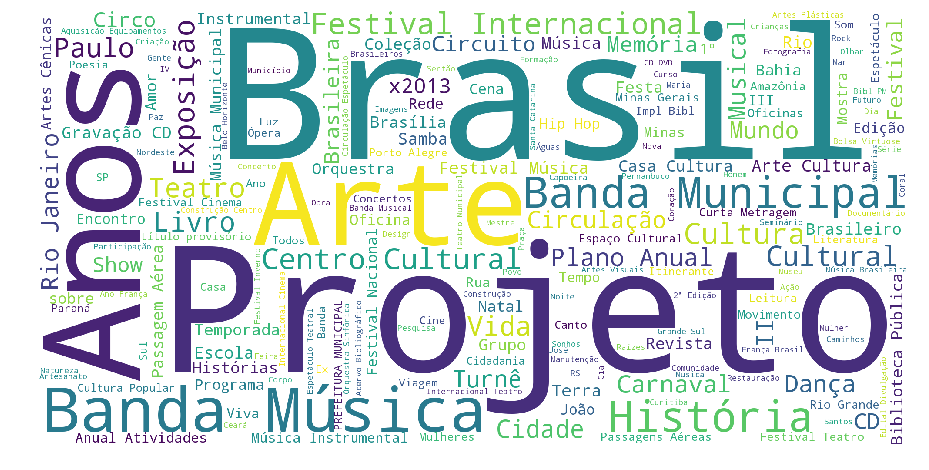

In [19]:
corpus = ' '.join(df['NomeProjeto'].astype('str').unique())

img = WordCloud(
    background_color='white',
    stopwords=stopwords.words('portuguese'),
    height=1000,
    width=2000,
    normalize_plurals=False
).generate(corpus)

plt.figure(figsize(16,8))
plt.imshow(img)
plt.axis('off');

#### Feature: situação atual dos projetos

In [20]:
serie = df['Situacao'].value_counts()
print(len(serie))
serie.head(10)

204


K00    73102
E63    12888
G51    11947
E24    11561
G37     8221
E19     7353
E36     6914
E10     5447
E65     5447
G52     3945
Name: Situacao, dtype: int64

#### Feature: unidade/local de análise dos projetos

In [21]:
serie = df['UnidadeAnalise'].value_counts()
print(len(serie))
serie.head(10)

47


              140237
FUNARTE        30429
FBN            12196
SAC/Ad hoc     10443
IPHAN           4234
COGMEC          3274
CAP             1523
SEXEC           1336
SDAV            1087
COP              917
Name: UnidadeAnalise, dtype: int64

#### Feature: analista responsável pelo projeto

In [22]:
serie = df['Analista'].value_counts()
print(len(serie))
serie.head(10)

1064


                                     91050
Tânia Regina Boita                    9329
Napoleão                              5158
Eunice Linhares Reis                  3626
Márcio Silva de Freitas               2892
Napoleão Alvarenga Filho              2618
Solange Monteiro Almeida              2574
Elisângela Roquete de Melo            2547
Maria das Neves Alves de Oliveira     2525
Edmo                                  2511
Name: Analista, dtype: int64

#### Feature: resumo do projeto

In [23]:
serie = df['ResumoProjeto'].value_counts()
print(len(serie))
serie = serie[ serie > 1 ]
print(len(serie))
serie.head(10)

205211
1360


A proposta enviada via postal (Correio), encontra-se junto a documentação obrigatória (anexo 1).    391
Acervo                                                                                              309
Doação de livros e estantes (kit acervo bibliográfico) para Implantação de Biblioteca Pública.      240
Solicita recursos para aquisição de instrumentos musicais                                           174
Doação de 2.592 livros e 6 estantes para Implantação de Biblioteca Municipal                        161
Documentação enviada pelo correio. O anexo 1 encontra-se junto a documentação obrigatoria           138
Implantação de biblioteca pública                                                                   135
Aquisição de instrumentos musicais                                                                  124
Doação de 2.119 livros e 04 estantes para Implantação de Biblioteca Pública.                        103
Doação de 2.119 livros e 04 estantes para Implantação de Bibliot

Alguns projetos têm resumos idênticos, cerca de 2.4% dos projetos têm resumos que não são únicos, sendo "A proposta enviada via postal (Correio), encontra-se junto a documentação obrigatória (anexo 1)." o resumo mais comum de projetos culturais, presente em 391 projetos distintos.

Abaixo é apresentada uma nuvem de palavras com as palavras e colocações mais frequentes nos resumos de projetos culturais.

In [24]:
import html
df['ResumoProjeto_utf-8'] = df['ResumoProjeto'].apply(lambda x: html.unescape(x))

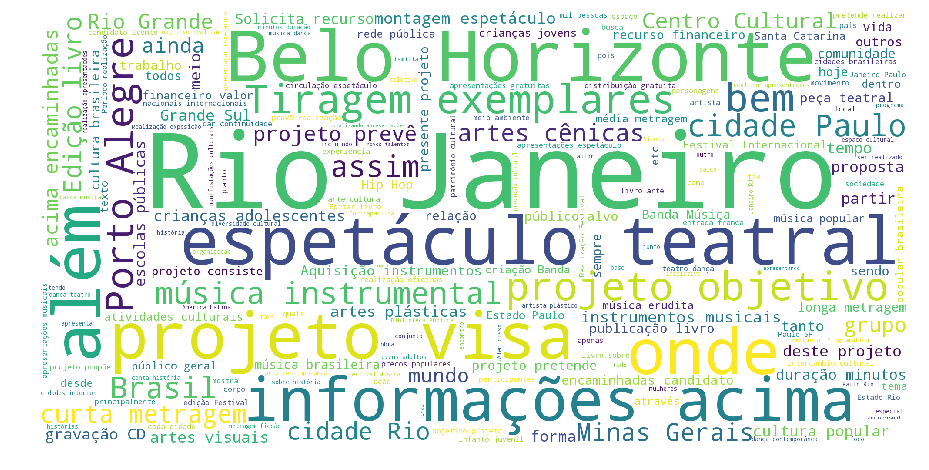

In [25]:
corpus = ' '.join(df['ResumoProjeto_utf-8'].astype('str').unique())

img = WordCloud(
    background_color='white',
    stopwords=stopwords.words('portuguese'),
    height=1000,
    width=2000,
    normalize_plurals=False
).generate(corpus)

plt.figure(figsize(16,8))
plt.imshow(img)
plt.axis('off');

#### Feature: providência tomada

In [26]:
serie = df['ProvidenciaTomada'].value_counts()
print(len(serie))
serie.head(10)

61328


Proposta transformada em projeto cultural                                                             21593
Nada captou - projeto arquivado                                                                       20846
Prorrogação aprovada e publicada no Di&aacute;rio Oficial da Uni&atilde;o.                             4608
Projeto arquivado (24 meses sem captação)                                                              4206
Projeto arquivado definitivamente, tendo  em vista encerramento do prazo de 24 meses sem captação.     3457
Impossibilidade de atendimento.                                                                        3208
Arquivado nada Captou/A pedido do proponente.                                                          3005
PRAZO DE CAPTAÇÃO DE RECURSOS ENCERRADO.                                                               2855
projeto não selecionado no edital                                                                      2849
Nada captou - Projeto arquiv

#### Feature: localização do projeto (entre os órgãos do governo)

In [27]:
serie = df['Localizacao'].value_counts()
print(len(serie))
serie.head(10)

8698


                    177556
SPOA/DCA              2541
DCA                   2134
SEFIC/CGAA            1223
SSD                    901
SAV/CEP                806
DCA/SPOA               738
FBN-RIO                595
ARQUIVO GERAL          588
SEFIC/PASSIVO/G1       291
Name: Localizacao, dtype: int64

Na análise das features textuais acima, foi possível identificar diversas características de projetos culturais, como:

1. Todos os PRONACs são de fato únicos e númericos;
1. Mais da metade dos projetos são iniciativas da região sudeste, sendo São Paulo o estado com a maior quantidade de projetos culturais;
1. Muitos projetos têm nomes repetidos e as palavras Brasil, Projeto e Arte estão entre as mais utilizadas nos nomes de projetos;
1. Mais da metade dos projetos estão em uma das quatro situações: K00, E63, G51 ou E24. Sendo K00 a situação na qual mais projetos se encontram;
1. 70% dos projetos não estão vinculados a nenhuma unidade de análise, do restante, a unidade que mais têm projetos vinculados é a FUNARTE;
1. Quase metade dos projetos não estão vinculados a nenhum analista. O restante está distribuído entre 1063 analistas, contudo, parte desses analistas são fictícios, com nomes como "q", "xx", "VAL", "Não Consta" e etc;
1. Alguns projeto têm também resumos repetidos. Dentre as palavras mais utilizadas em resumos estão nomes de capitais de estados brasileiros;
1. As principais providências tomadas em projetos estão "proposta transformada em projeto" e "projeto arquivado", contudo, várias providências podem ser tomadas ao longo de um projeto, a apresentada deve ser apenas a última providência tomada no projeto;
1. Quase 85% dos projetos não tem localização definida, tornando essa feature não muito útil. Do restante, as localizações mais frequentes são: SPOA/DCA, DCA e SEFIC/CGAA.

---
## Desenvolvimento

Nesta seção, serão apresentadas diversas estratégias para ranquear os projetos mais similares a um projeto cultural específico.

### Primeiro modelo: olhando apenas os nomes dos projetos

O primeiro modelo de identificação de projetos similares vai levar em consideração apenas o nome dos projetos, ou seja, dado um PRONAC específico, será gerado um rank dos projetos com os nomes mais parecidos com aquele.

Para começar, serão extraídos apenas o identificador (PRONAC) e o nome dos projetos culturais. Em seguida, serão realizadas as seguintes etapas de pré-processamento:

1. Remoção de caracteres não alfanuméricos;
1. Passagem de todos os nomes para minúsculos;
1. Identificação de colocações (bigramas);
1. Segmentação dos nomes (tokenize);
1. Remoção de palavras vazias (stopwords);
1. Redução das palavras flexionadas à sua base ou raiz (stemming).

Após todas as etapas de pré-processamento, será utilizada a técnica de "Bag of Words", criando-se um vetor de frequências das palavras, onde as palavras mais frequentes serão selecionadas como features e então será criado, treinado e testado o modelo.

#### Extração do nome dos projetos

In [28]:
projects = df[['PRONAC', 'NomeProjeto']].copy()
projects.rename(inplace=True, columns={
    'NomeProjeto': 'name',
    'PRONAC': 'id'
})
projects.set_index('id', inplace=True)
projects['name'] = projects['name'].astype('str')
projects.head()

,name
id,
087079,"São Paulo; O que foi, O que era e o que é"
087080,Festival BrasilNoar 2008 – 8° Festival Interna...
087081,Festival BrasilNoar 2008 – 8° Festival Interna...
087082,"Exposição "" Eliseu Visconti - Retrospectiva"""
087083,Príncipe Feliz (O)


#### Remoção de caracteres não-alfanuméricos

In [29]:
import re
projects['name'] = projects['name'].apply(lambda x: re.sub('[^\w]', ' ', x))
projects.head()

,name
id,
087079,São Paulo O que foi O que era e o que é
087080,Festival BrasilNoar 2008 8 Festival Interna...
087081,Festival BrasilNoar 2008 8 Festival Interna...
087082,Exposição Eliseu Visconti Retrospectiva
087083,Príncipe Feliz O


#### Tranformação de todos os caracteres para minúsculo

In [30]:
projects['name'] = projects['name'].apply(lambda x: x.lower())
projects.head()

,name
id,
087079,são paulo o que foi o que era e o que é
087080,festival brasilnoar 2008 8 festival interna...
087081,festival brasilnoar 2008 8 festival interna...
087082,exposição eliseu visconti retrospectiva
087083,príncipe feliz o


#### Identificação de colocações

Antes de realizar a segmentação do texto, encontrou-se as colocações mais comuns. Desta forma, ao segmentar o texto, colocações muito comuns são tratadas como uma única palavra.

In [31]:
x = ' '.join(projects['name'].values).split()

stop_words = stopwords.words('portuguese')
bigrams = nltk.bigrams([w for w in x if  w == 'são' or w not in stop_words])

collocations = nltk.FreqDist(bigrams).most_common(500)
collocations = list(map(lambda x: x[0], collocations))
collocations[:10]

[('centro', 'cultural'),
 ('biblioteca', 'pública'),
 ('banda', 'música'),
 ('banda', 'municipal'),
 ('festival', 'internacional'),
 ('são', 'paulo'),
 ('implantação', 'biblioteca'),
 ('plano', 'anual'),
 ('doação', 'kit'),
 ('rio', 'janeiro')]

#### Segmentação dos nomes

In [32]:
def tokenize(x):
    words = x.split()
    tokens = []
    
    is_token = False
    for i in range(len(words)):
        if is_token:
            is_token = False
        elif i+1 == len(words):
            tokens.append(words[i])
        elif (words[i], words[i+1]) in collocations:
            tokens.append('{}_{}'.format(words[i], words[i+1]))
            is_token = True
        elif words[i] != 'são':
            tokens.append(words[i])
    
    return tokens

projects['name'] = projects['name'].apply(tokenize)
projects.head()

,name
id,
087079,"[são_paulo, o, que, foi, o, que, era, e, o, qu..."
087080,"[festival, brasilnoar, 2008, 8, festival_inter..."
087081,"[festival, brasilnoar, 2008, 8, festival_inter..."
087082,"[exposição, eliseu, visconti, retrospectiva]"
087083,"[príncipe, feliz, o]"


#### Remoção de palavras vazias

In [33]:
stop_words = stopwords.words('portuguese')
projects['name'] = projects['name'].apply(lambda x: [w for w in x if w not in stop_words])
projects.head()

,name
id,
087079,"[são_paulo, é]"
087080,"[festival, brasilnoar, 2008, 8, festival_inter..."
087081,"[festival, brasilnoar, 2008, 8, festival_inter..."
087082,"[exposição, eliseu, visconti, retrospectiva]"
087083,"[príncipe, feliz]"


#### Redução de palavras flexionadas

In [34]:
stemmer = RSLPStemmer()
projects['name'] = projects['name'].apply(lambda x: [stemmer.stem(w) for w in x])
projects.head()

,name
id,
087079,"[são_paul, é]"
087080,"[festiv, brasilno, 2008, 8, festival_internac,..."
087081,"[festiv, brasilno, 2008, 8, festival_internac,..."
087082,"[expos, elis, viscont, retrospec]"
087083,"[príncip, feliz]"


#### Criação da "Bag of Words"

In [35]:
data = projects['name'].apply(lambda x: ' '.join(x)).values
matrix = CountVectorizer(max_features=1000)
X = matrix.fit_transform(data).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### Utilizando o algoritmo KNN para encontrar os projetos mais similares a um projeto específico

In [44]:
nbrs = NearestNeighbors(n_neighbors=10).fit(X)

In [77]:
pronacs = projects.index.values
def neighbors(pronac):
    i = 0
    while pronacs[i] != pronac:
        i += 1
        if i == len(pronacs):
            raise ValueError('PRONAC "{}" not found.'.format(pronac))
    
    print('Projeto base:')
    display(df.iloc[i:i+1][['PRONAC', 'NomeProjeto']])
    
    print()
    print('Top projetos similares:')
    d, indices = nbrs.kneighbors([X[i]])
    display(df.iloc[indices[0]][['PRONAC', 'NomeProjeto']])

#### Testando o detector de similaridade

In [78]:
neighbors('128276')

Projeto base:


,PRONAC,NomeProjeto
156065,128276,Santander Cultural - 2013 - Plano Anual de Ati...



Top projetos similares:


,PRONAC,NomeProjeto
156065,128276,Santander Cultural - 2013 - Plano Anual de Ati...
155915,128126,Plano Anual de Atividades Cultura 2013
156102,128313,Plano Anual de Atividades 2013 - Itaú Cultural
155939,128150,Plano Anual de Atividades Arte & Vida 2013
155652,127863,Plano Anual de Atividades Santa Marcelina Cult...
155881,128092,Plano Anual de Atividades 2013
156223,128434,Plano Anual de Atividades Poiesis 2013
154625,126836,Plano Anual de Atividades Osesp 2013
155143,127354,Plano Anual de Atividades 2013
156105,128316,Plano Anual de Atividades 2013


In [79]:
neighbors('087079')

Projeto base:


,PRONAC,NomeProjeto
0,087079,"São Paulo; O que foi, O que era e o que é"



Top projetos similares:


,PRONAC,NomeProjeto
0,087079,"São Paulo; O que foi, O que era e o que é"
11033,014421,Almanaque São Paulo
8656,011477,"São Paulo, Metrópole"
10906,014289,"""Os Portugueses em São Paulo"""
8203,011018,Enciclopédia de São Paulo
8456,011275,Almanaque São Paulo
10140,013490,Polaroids em São Paulo
1744,000868,Mosaico de São Paulo
2314,001485,PercPan - São Paulo
10473,013829,Eu Sou São Paulo


---
## Resultados e Conclusões

Apresentação dos resultados de desempenho, precisão, acurácia, análise dos gráficos e algoritmos.

Por fim, discussão do que foi implementado e apresentação das melhores alternativas de algoritmos e tecnologias, além de um possível levantamento de trabalhos futuros.